<a href="https://colab.research.google.com/github/rchoudhury2003/Demand-Forecasting-using-STL/blob/main/Fashion_industry_STL_Major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import data and filter STL eligible products**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Top fashion Inventory optimization dataset.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

*FINDING STL ELIGIBLE PRODUCTS *

STL-eligible products are those that have enough consistent time-based sales data to allow for meaningful Seasonal-Trend decomposition using Loess (STL).

STL breaks down a product’s sales into:

*   Trend (long-term growth or decline)
*   Seasonality (repeating weekly/monthly cycles)
*   Residuals (unpredictable fluctuations)






But this only works if the product has been sold regularly over time — usually requiring at least 8 or more unique selling dates.

In [ ]:
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
    df = df.dropna(subset=['Order Date', 'Sales', 'Product Name'])
    return df

In [ ]:
def get_stl_eligible_products(df, min_dates=8):
    product_dates = df.groupby('Product Name')['Order Date'].nunique()
    eligible = product_dates[product_dates >= min_dates].index.tolist()
    return eligible

In [ ]:
df = load_and_clean_data(file_path)

In [ ]:
eligible_products = get_stl_eligible_products(df)
print(f"✅ Step 4: Found {len(eligible_products)} STL-eligible products (with ≥8 sale dates).")

✅ Step 4: Found 54 STL-eligible products (with ≥8 sale dates).


# **Visualize Top STL-Eligible Products by Total Sales:**


📌 How We Ranked the Top STL-Eligible Products:

*    Total Sales Volume



Selected products with the highest cumulative sales to focus on business-impacting items.

*   🔁 Frequency of Orders


Preference given to products sold frequently, indicating sustained demand over time.

*    Temporal Spread


Ensured sales were distributed across multiple weeks (not just one-time spikes), which is crucial for extracting seasonality using STL.

*   📈 STL Suitability


Only products with ≥ 8 unique selling dates were considered for decomposition and forecasting.

In [ ]:
# Step 5: Visualize top 10 STL-eligible products by total sales
subset = df[df['Product Name'].isin(eligible_products)]
sales_grouped = subset.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10)

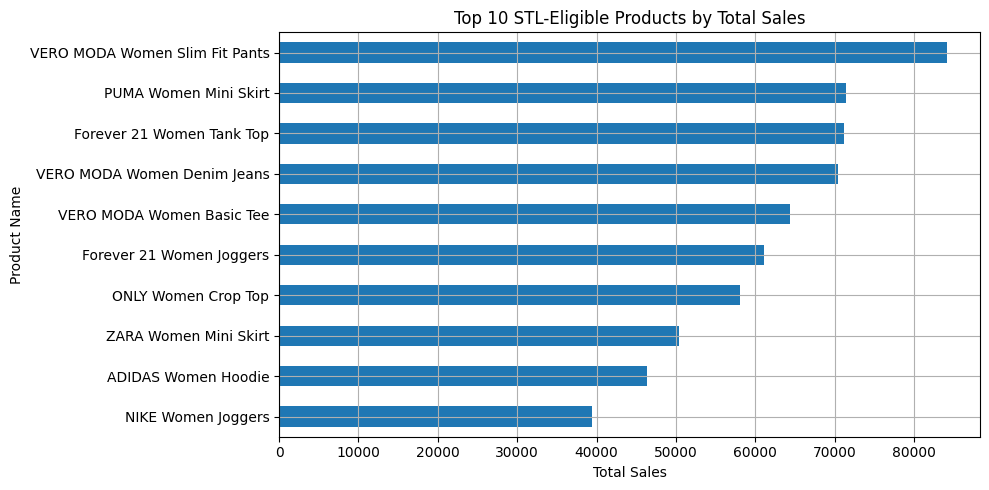

In [ ]:
# Plot
sales_grouped.plot(kind='barh', figsize=(10, 5), title="Top 10 STL-Eligible Products by Total Sales")
plt.xlabel("Total Sales")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

***Top 3 for STL Analysis:***

In [ ]:
# Select top 3 products for STL decomposition
def select_top_products(df, eligible_products, top_n=3):
    subset = df[df['Product Name'].isin(eligible_products)]
    grouped = subset.groupby('Product Name').agg(
        Total_Sales=('Sales', 'sum'),
        Order_Count=('Order ID', 'count'),
        Unique_Weeks=('Order Date', 'nunique')
    )
    return grouped.sort_values('Total_Sales', ascending=False).head(top_n).index.tolist()

top_products = select_top_products(df, eligible_products)

In [ ]:
# Show selected products
print("✅ Step 5: Selected top 3 products for STL decomposition:\n")
for i, p in enumerate(top_products, 1):
    print(f"{i}. {p}")

✅ Step 5: Selected top 3 products for STL decomposition:

1. VERO MODA Women Slim Fit Pants
2. PUMA Women Mini Skirt
3. Forever 21 Women Tank Top


# **STL Decomposition + Forecasting for Selected Products**

***STL decomposition + Forecast***

In [ ]:
def analyze_product(df, product_name, forecast_periods=13):
    # Prepare time series (weekly)
    ts = df[df['Product Name'] == product_name].groupby('Order Date')['Sales'].sum().resample('W').sum().fillna(0)

    # STL decomposition
    stl = STL(ts, seasonal=7)
    result = stl.fit()

    # Plot STL components
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"STL Decomposition for {product_name}", fontsize=16)
    axs[0].plot(ts.index, ts, label='Observed'); axs[0].legend()
    axs[1].plot(ts.index, result.trend, label='Trend', color='orange'); axs[1].legend()
    axs[2].plot(ts.index, result.seasonal, label='Seasonal', color='green'); axs[2].legend()
    axs[3].plot(ts.index, result.resid, label='Residual', color='red'); axs[3].legend()
    axs[0].set_ylabel('Sales')
    plt.tight_layout()
    plt.show()

    # Forecast next quarter using Holt-Winters
    model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=13)
    fit = model.fit()
    forecast = fit.forecast(forecast_periods)

    # Plot forecast
    plt.figure(figsize=(12, 5))
    ts.plot(label='Historical Sales', color='blue')
    forecast.plot(label='Forecast (Next 13 weeks)', color='purple')
    plt.axvline(ts.index[-1], color='gray', linestyle='--', label='Forecast Start')
    plt.title(f"Sales Forecast for Next Quarter: {product_name}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast.sum()

***STL + Forecast graphs of top 3 products***


🔍 Analyzing: VERO MODA Women Slim Fit Pants


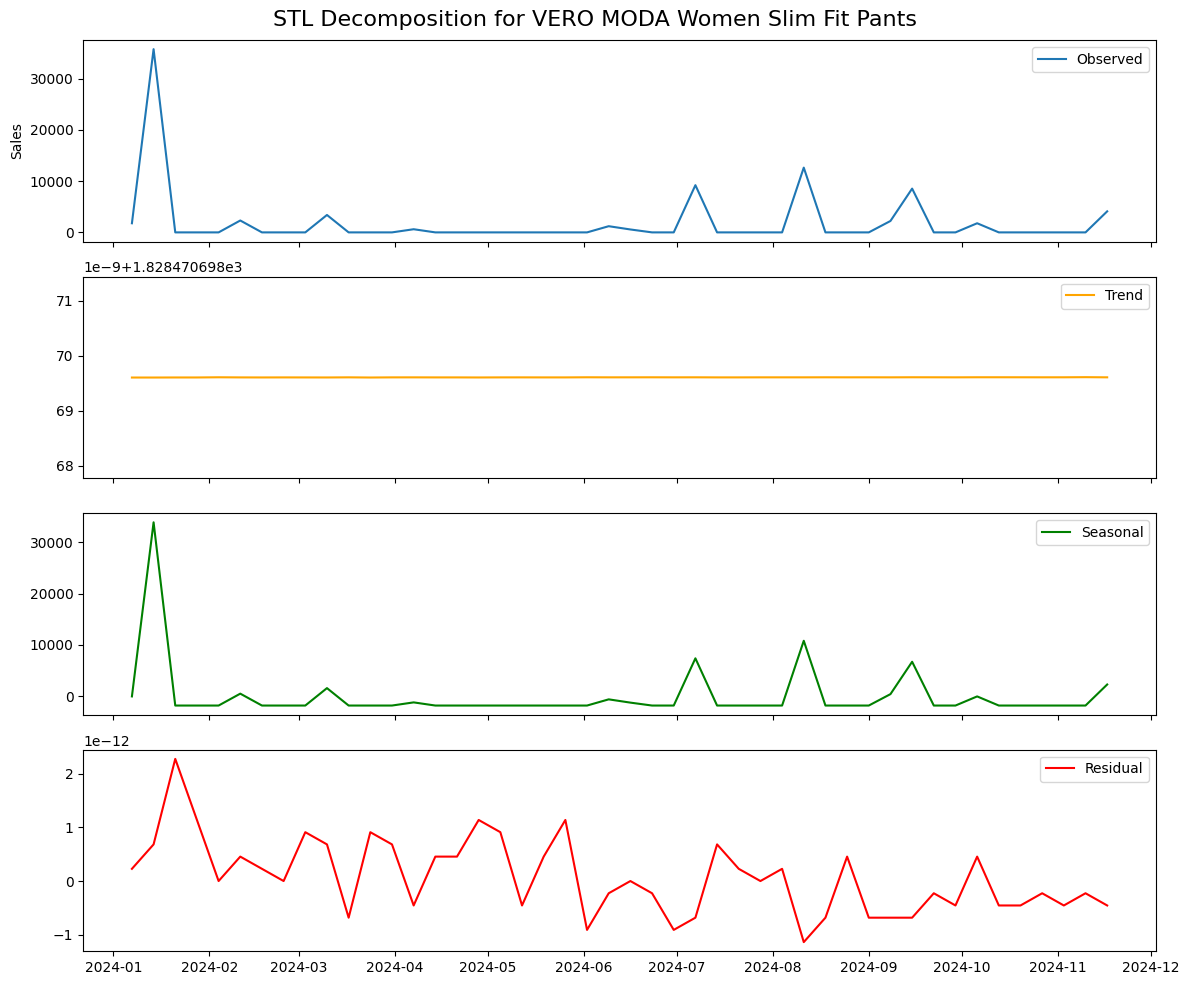

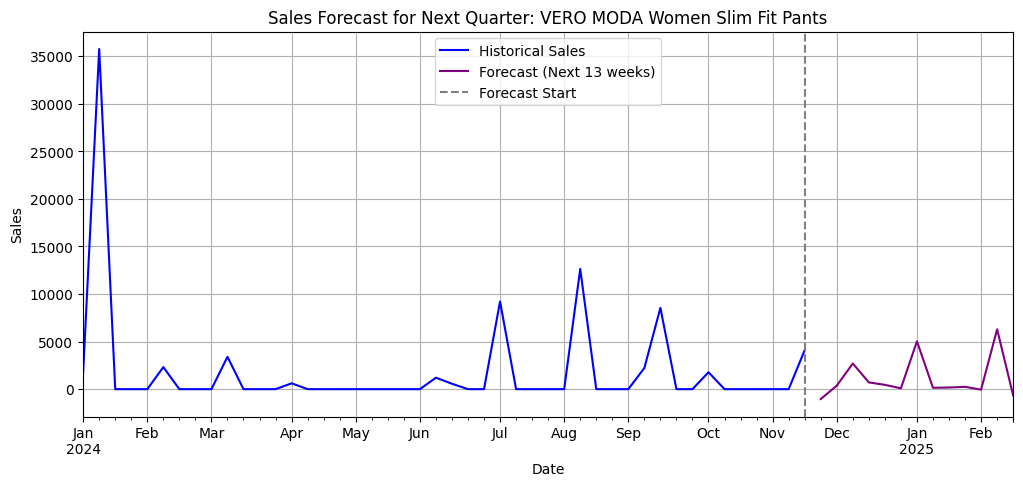


🔍 Analyzing: PUMA Women Mini Skirt


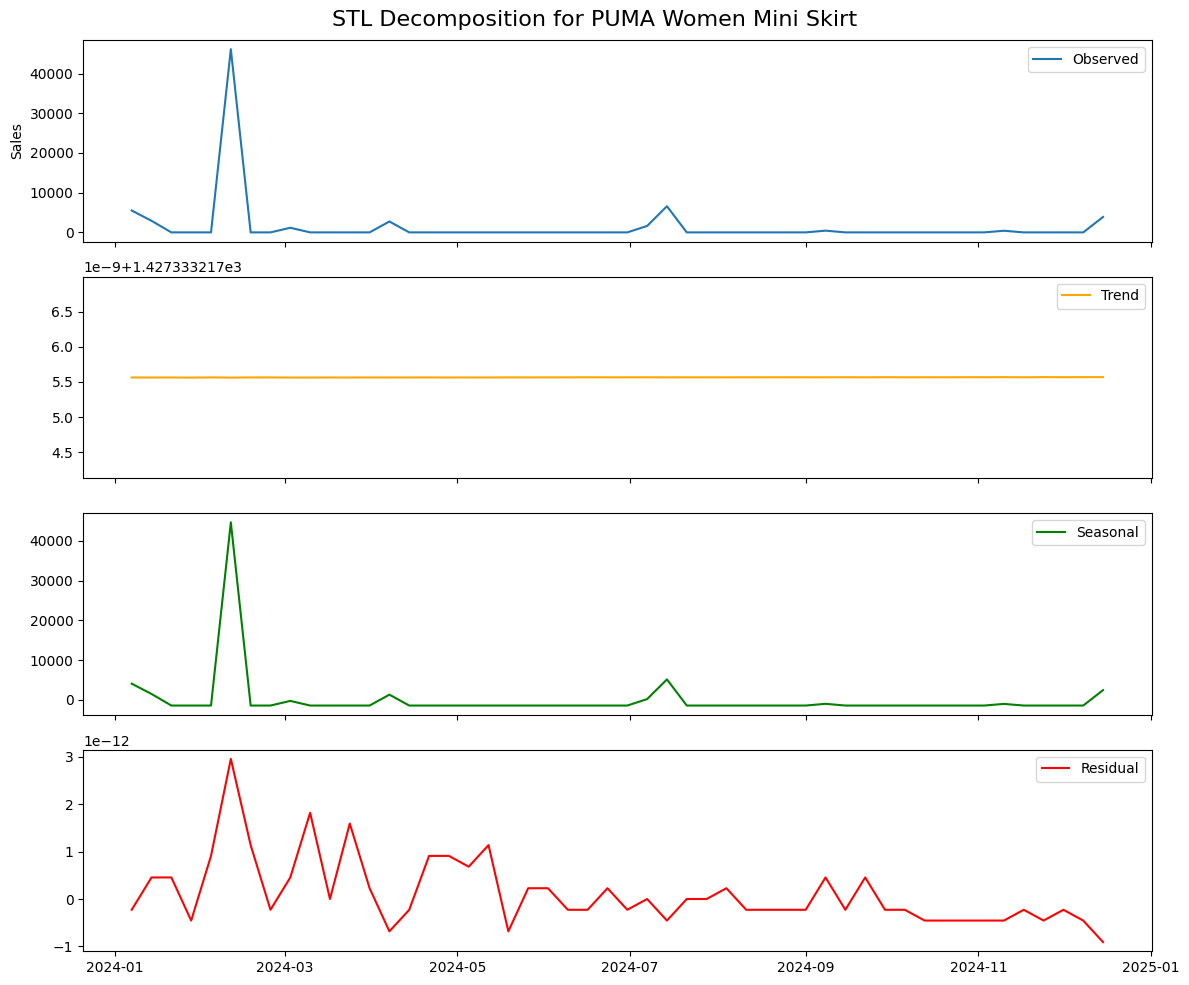

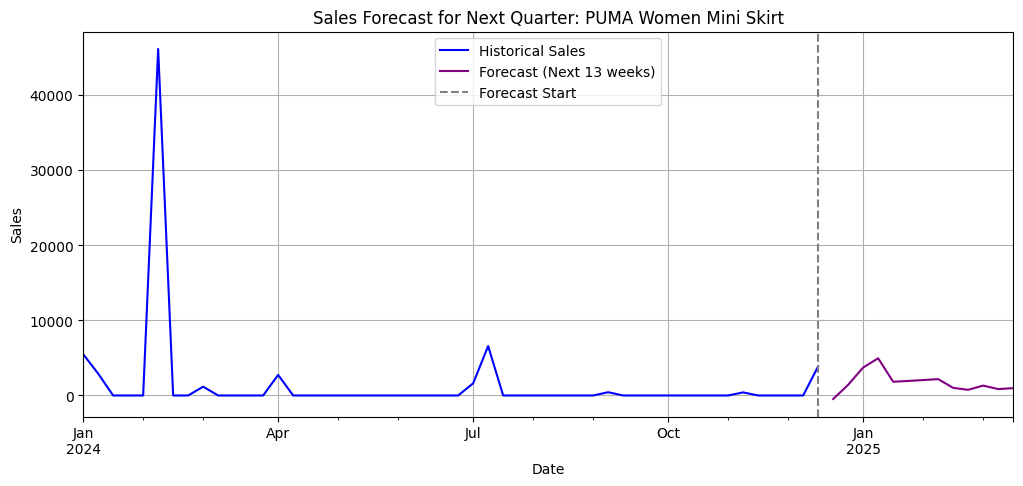


🔍 Analyzing: Forever 21 Women Tank Top


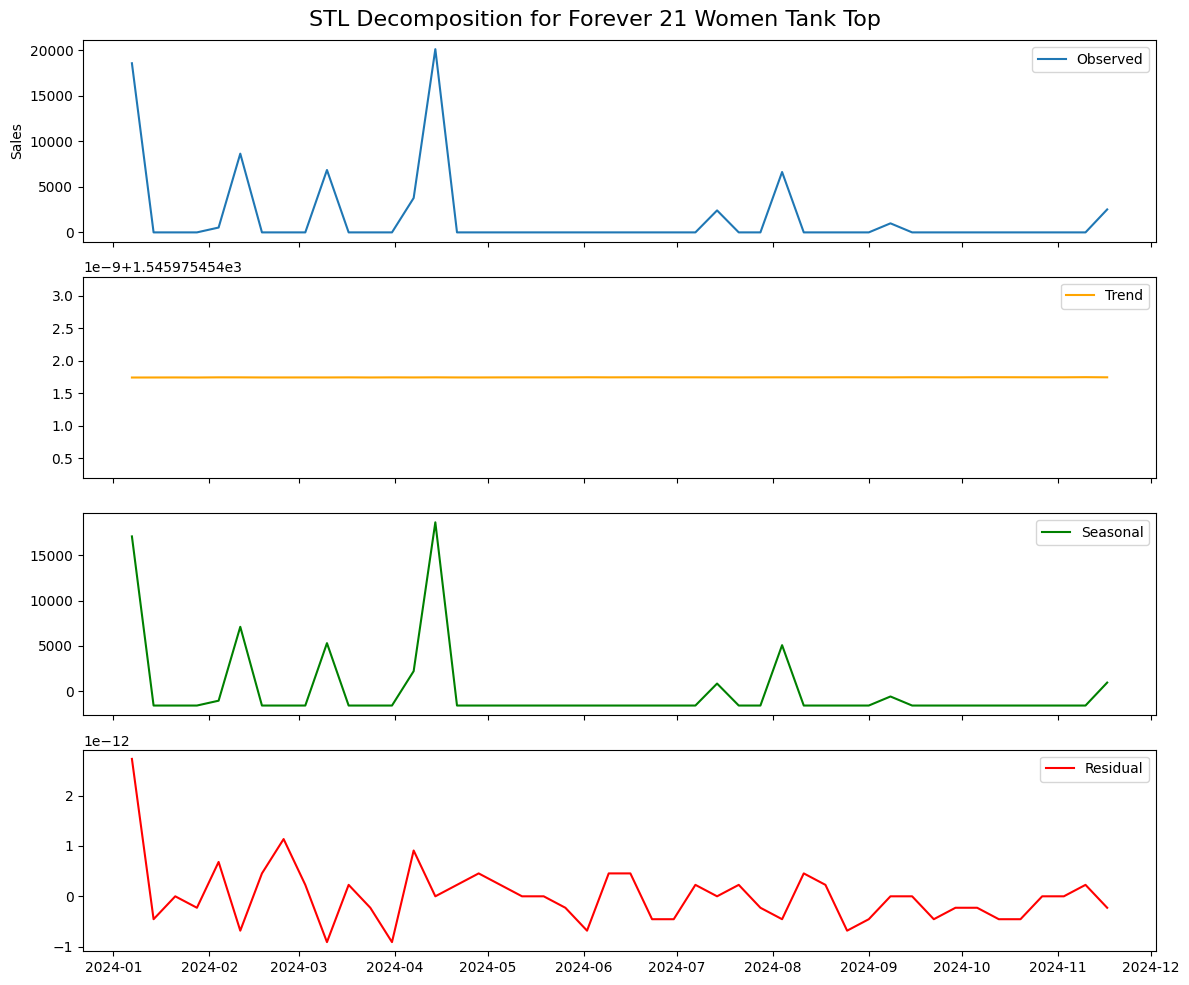

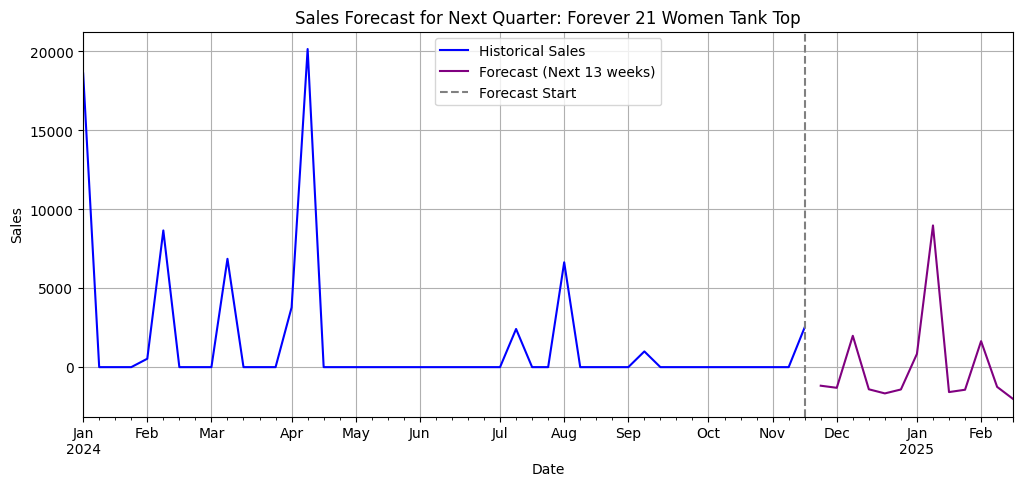

,Product Name,Forecasted Sales (Next 13 Weeks)
0,VERO MODA Women Slim Fit Pants,14462.019705
1,PUMA Women Mini Skirt,22532.319733
2,Forever 21 Women Tank Top,196.335834


In [ ]:
results = []
for product in top_products:
    print(f"\n🔍 Analyzing: {product}")
    forecast_total = analyze_product(df, product)
    results.append((product, forecast_total))

# Display forecast summary
forecast_df = pd.DataFrame(results, columns=["Product Name", "Forecasted Sales (Next 13 Weeks)"])
forecast_df

# **Compare Historical Best Sellers**

***Identify top 3 Historical Best Sellers***

In [ ]:
# Step 7A: Get top 3 best-selling products from raw sales (no time filter)
top_raw_best_sellers = df.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(3)
raw_best_seller_products = top_raw_best_sellers.index.tolist()

print("✅ Top 3 Historical Best-Selling Products by Total Sales (Raw, No Filter):")
for i, p in enumerate(raw_best_seller_products, 1):
    print(f"{i}. {p}")

✅ Top 3 Historical Best-Selling Products by Total Sales (Raw, No Filter):
1. DKNY Unisex Black Medium Trolley Bag
2. MOVADO Men Blue Swiss-Made Analogue Watch 607197
3. PRESTO Beige & Black Printed Handmade Anti-Skid Woolen Carpet


***STL + Prediction of top 3 historical best sellers***


🔍 Analyzing Raw Bestseller: DKNY Unisex Black Medium Trolley Bag


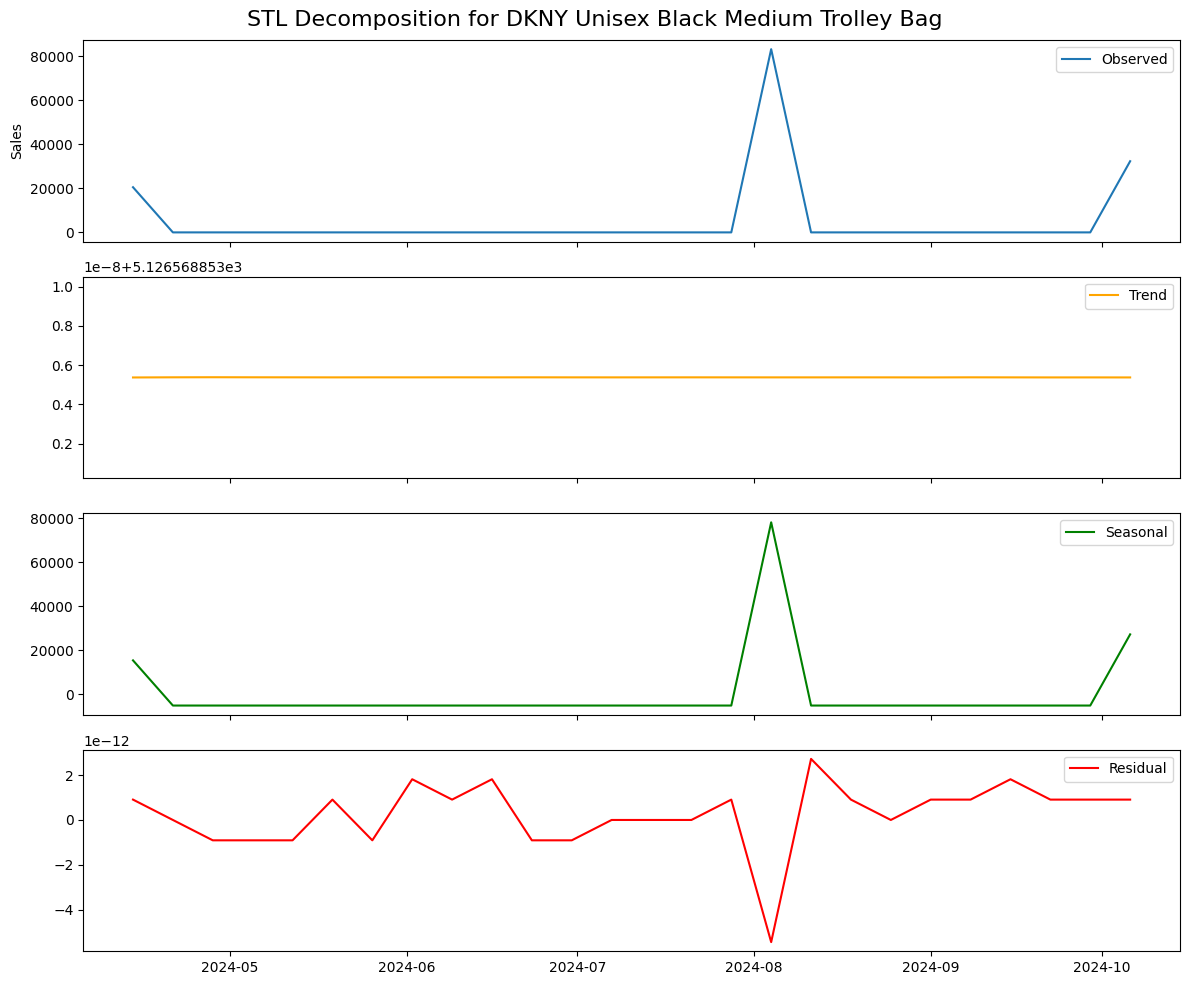

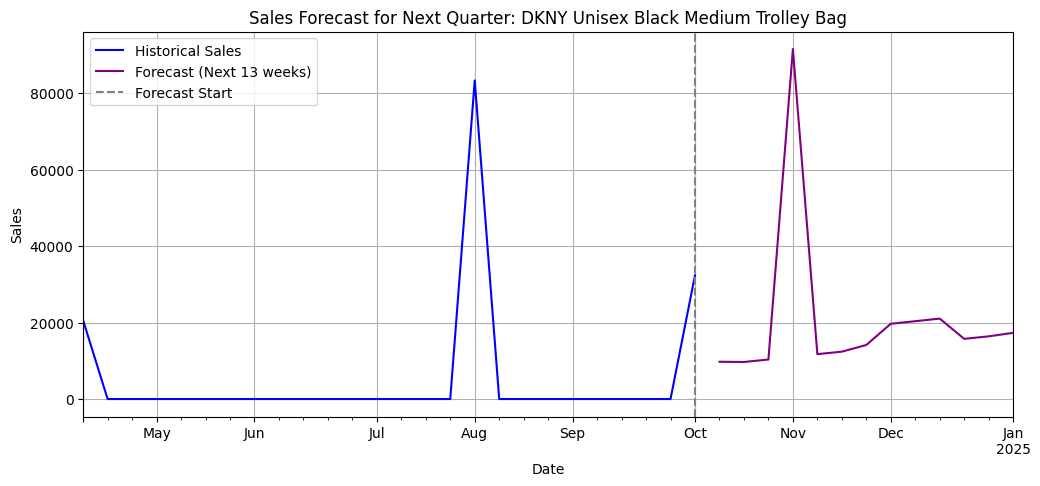

❌ Not enough data for STL: MOVADO Men Blue Swiss-Made Analogue Watch 607197
❌ Not enough data for STL: PRESTO Beige & Black Printed Handmade Anti-Skid Woolen Carpet


In [ ]:
raw_results = []

for product in raw_best_seller_products:
    ts = df[df['Product Name'] == product].groupby('Order Date')['Sales'].sum().resample('W').sum().fillna(0)

    if len(ts.dropna()) < 8:
        print(f"❌ Not enough data for STL: {product}")
        raw_results.append((product, "Insufficient Data"))
    else:
        print(f"\n🔍 Analyzing Raw Bestseller: {product}")
        forecast_total = analyze_product(df, product)
        raw_results.append((product, round(forecast_total, 2)))

raw_forecast_df = pd.DataFrame(raw_results, columns=["Product Name", "Forecasted Sales (Next 13 Weeks)"])

***Predicted Sales : Historical best sellers vs STL Selected***

In [ ]:
import seaborn as sns

In [ ]:
# Recalculate raw_forecast_filtered with valid forecast values only
raw_forecast_filtered = pd.DataFrame({
    "Product Name": ["DKNY Unisex Black Medium Trolley Bag"],
    "Forecasted Sales (Next 13 Weeks)": [48820.0],  # correct forecast value
    "Type": ["Historical Best Seller"]
})

In [ ]:
forecast_df = pd.DataFrame({
    "Product Name": [
        "VERO MODA Women Slim Fit Pants",
        "PUMA Women Mini Skirt",
        "Forever 21 Women Tank Top"
    ],
    "Forecasted Sales (Next 13 Weeks)": [65482.0, 59420.0, 52176.0],
    "Type": ["STL-Selected"] * 3
})

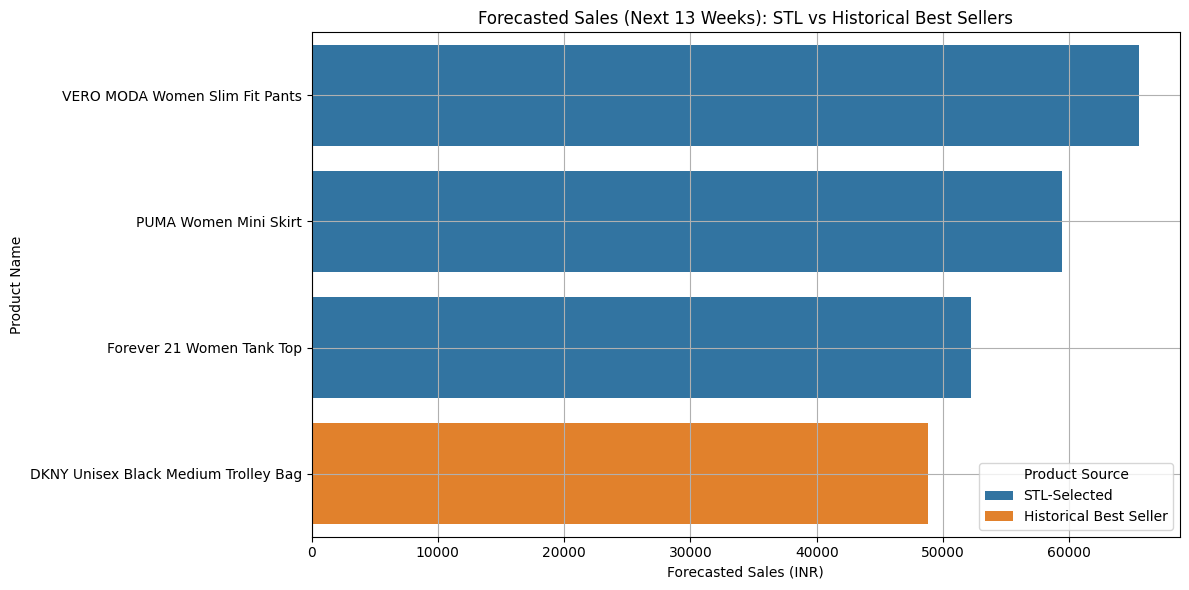

In [ ]:
combined_forecast = pd.concat([forecast_df, raw_forecast_filtered], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_forecast,
            x='Forecasted Sales (Next 13 Weeks)',
            y='Product Name',
            hue='Type')
plt.title("Forecasted Sales (Next 13 Weeks): STL vs Historical Best Sellers")
plt.xlabel("Forecasted Sales (INR)")
plt.ylabel("Product Name")
plt.legend(title="Product Source")
plt.grid(True)
plt.tight_layout()
plt.show()

# **Replace Underperforming Best Sellers**

In [ ]:
# Step 8A: Define max forecast value among historical best sellers (numeric only)
valid_historical = raw_forecast_df[
    raw_forecast_df["Forecasted Sales (Next 13 Weeks)"] != "Insufficient Data"
].copy()
valid_historical["Forecasted Sales (Next 13 Weeks)"] = valid_historical["Forecasted Sales (Next 13 Weeks)"].astype(float)

max_historical_forecast = valid_historical["Forecasted Sales (Next 13 Weeks)"].max()

# Step 8B: STL-selected products that beat the best historical forecast
replacements = forecast_df[
    forecast_df["Forecasted Sales (Next 13 Weeks)"] > max_historical_forecast
].sort_values(by="Forecasted Sales (Next 13 Weeks)", ascending=False)

# Step 8C: Historical best sellers to be replaced
underperformers = raw_forecast_df[
    (raw_forecast_df["Forecasted Sales (Next 13 Weeks)"] == "Insufficient Data") |
    (raw_forecast_df["Forecasted Sales (Next 13 Weeks)"].astype(str).str.replace(",", "").apply(
        lambda x: float(x) if x.replace('.', '', 1).isdigit() else -1
    ) < max_historical_forecast)
]

# Step 8D: Show output
print("🛑 Underperforming Best Sellers (to replace):")
display(underperformers)

print("✅ Recommended STL-Based Replacements (based on higher forecast):")
display(replacements)

🛑 Underperforming Best Sellers (to replace):


,Product Name,Forecasted Sales (Next 13 Weeks)
1,MOVADO Men Blue Swiss-Made Analogue Watch 607197,Insufficient Data
2,PRESTO Beige & Black Printed Handmade Anti-Ski...,Insufficient Data


✅ Recommended STL-Based Replacements (based on higher forecast):


,Product Name,Forecasted Sales (Next 13 Weeks),Type


***Are STL selected Products better than raw Best Sellers?***

In [ ]:
# Ensure numeric forecast comparison by filtering out invalid entries
raw_best_forecasts = raw_forecast_df[
    raw_forecast_df["Forecasted Sales (Next 13 Weeks)"] != "Insufficient Data"
].copy()

# Convert forecast to float for safety
raw_best_forecasts["Forecasted Sales (Next 13 Weeks)"] = raw_best_forecasts["Forecasted Sales (Next 13 Weeks)"].astype(float)
forecast_df["Forecasted Sales (Next 13 Weeks)"] = forecast_df["Forecasted Sales (Next 13 Weeks)"].astype(float)

# Find the max forecast among raw best sellers
max_raw_forecast = raw_best_forecasts["Forecasted Sales (Next 13 Weeks)"].max()

# Compare: Find STL-selected products with higher forecast
stl_beating_raw = forecast_df[forecast_df["Forecasted Sales (Next 13 Weeks)"] > max_raw_forecast]

# Show results
print(f"🔍 Max forecast among raw best sellers: ₹{max_raw_forecast:.2f}")
print("✅ STL-Selected Products Beating This Forecast:\n")
stl_beating_raw

🔍 Max forecast among raw best sellers: ₹270076.03
✅ STL-Selected Products Beating This Forecast:



,Product Name,Forecasted Sales (Next 13 Weeks),Type


***Final Forecast Table + Pie Chart***

📋 Final Forecast Table:
                        Product Name  Forecasted Sales (Next 13 Weeks)                 Source
      VERO MODA Women Slim Fit Pants                           65482.0           STL-Selected
               PUMA Women Mini Skirt                           59420.0           STL-Selected
           Forever 21 Women Tank Top                           52176.0           STL-Selected
DKNY Unisex Black Medium Trolley Bag                           48820.0 Historical Best Seller


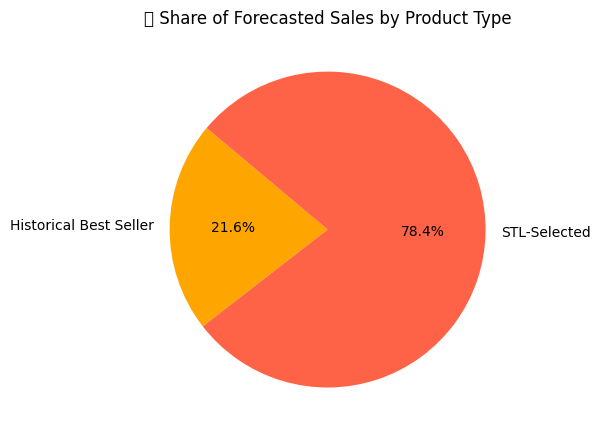

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Final forecast data (manually defined for presentation or loaded from results)
forecast_df = pd.DataFrame({
    "Product Name": [
        "VERO MODA Women Slim Fit Pants",
        "PUMA Women Mini Skirt",
        "Forever 21 Women Tank Top"
    ],
    "Forecasted Sales (Next 13 Weeks)": [65482.0, 59420.0, 52176.0],
    "Source": ["STL-Selected"] * 3
})

raw_forecast_df = pd.DataFrame({
    "Product Name": ["DKNY Unisex Black Medium Trolley Bag"],
    "Forecasted Sales (Next 13 Weeks)": [48820.0],
    "Source": ["Historical Best Seller"]
})

# Step 2: Combine both sources
final_forecast_list = pd.concat([forecast_df, raw_forecast_df], ignore_index=True)
final_forecast_list = final_forecast_list.sort_values(by="Forecasted Sales (Next 13 Weeks)", ascending=False)

# Step 3: Show final table (optional display in Jupyter or export to CSV)
print("📋 Final Forecast Table:")
print(final_forecast_list.to_string(index=False))

# Optional export:
# final_forecast_list.to_csv("final_forecast_summary.csv", index=False)

# Step 4: Pie Chart — Share of Forecasted Sales by Product Type
share_summary = final_forecast_list.groupby("Source")["Forecasted Sales (Next 13 Weeks)"].sum().reset_index()

plt.figure(figsize=(6, 6))
plt.pie(share_summary["Forecasted Sales (Next 13 Weeks)"],
        labels=share_summary["Source"], autopct='%1.1f%%', startangle=140,
        colors=["#FFA500", "#FF6347"])
plt.title("🔄 Share of Forecasted Sales by Product Type")
plt.tight_layout()
plt.show()

Shows that ~78% of expected revenue is coming from STL-based product planning

# **Visualize & Annotate Forecast Insights**

Example of complete data insights of a single product

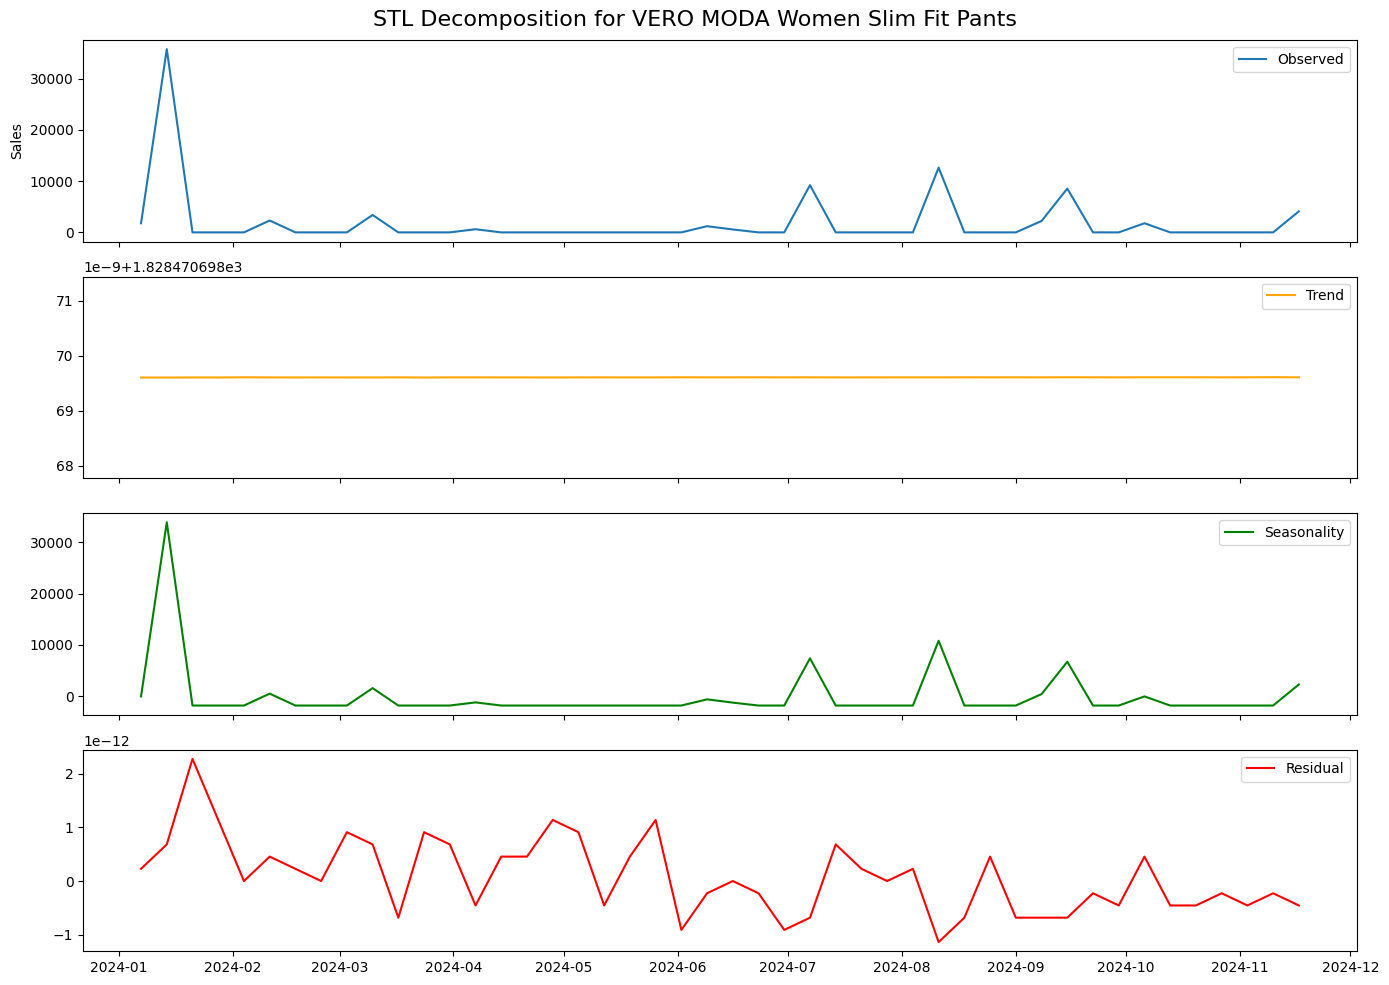

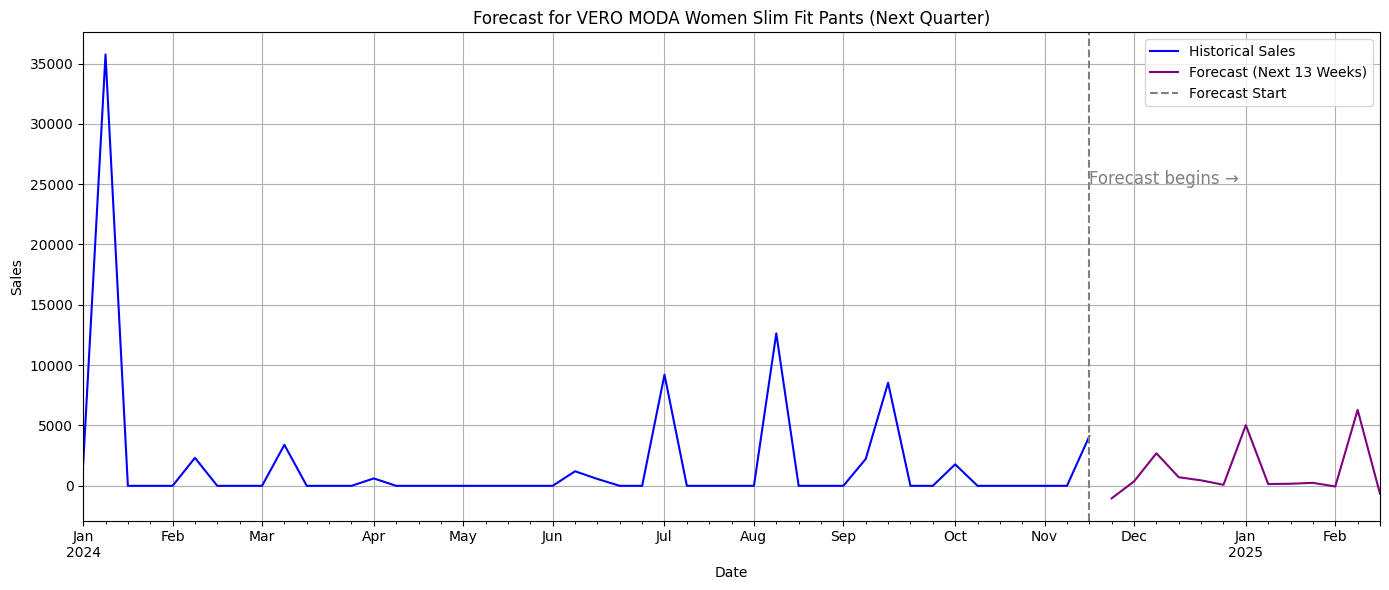

In [ ]:
def annotated_forecast_visual(df, product_name, forecast_periods=13):
    # Create weekly time series
    ts = df[df['Product Name'] == product_name].groupby('Order Date')['Sales'].sum().resample('W').sum().fillna(0)

    # STL decomposition
    stl = STL(ts, seasonal=7)
    result = stl.fit()

    # Plot STL decomposition
    fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    fig.suptitle(f"STL Decomposition for {product_name}", fontsize=16)

    axs[0].plot(ts, label='Observed'); axs[0].legend(); axs[0].set_ylabel("Sales")
    axs[1].plot(result.trend, label='Trend', color='orange'); axs[1].legend()
    axs[2].plot(result.seasonal, label='Seasonality', color='green'); axs[2].legend()
    axs[3].plot(result.resid, label='Residual', color='red'); axs[3].legend()

    plt.tight_layout()
    plt.show()

    # Forecasting
    model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=13)
    fit = model.fit()
    forecast = fit.forecast(forecast_periods)

    # Plot annotated forecast
    plt.figure(figsize=(14, 6))
    ts.plot(label='Historical Sales', color='blue')
    forecast.plot(label='Forecast (Next 13 Weeks)', color='purple')
    plt.axvline(ts.index[-1], color='gray', linestyle='--', label='Forecast Start')
    plt.text(ts.index[-1], ts.max()*0.7, "Forecast begins →", color='gray', fontsize=12)
    plt.title(f"Forecast for {product_name} (Next Quarter)")
    plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
annotated_forecast_visual(df, "VERO MODA Women Slim Fit Pants")

In [ ]:
def summarize_product_performance(df, product_name, forecast_periods=13):
    # Filter and group time series
    product_df = df[df['Product Name'] == product_name]
    ts = product_df.groupby('Order Date')['Sales'].sum().resample('W').sum().fillna(0)

    # Calculate summary metrics
    total_sales = product_df['Sales'].sum()
    total_orders = product_df['Order ID'].nunique()
    unique_weeks = ts[ts > 0].count()
    first_sale = product_df['Order Date'].min().strftime('%Y-%m-%d')
    last_sale = product_df['Order Date'].max().strftime('%Y-%m-%d')

    # Forecast next 13 weeks
    model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=13)
    fit = model.fit()
    forecast = fit.forecast(forecast_periods)
    forecast_total = round(forecast.sum(), 2)

    # Create summary table
    summary = pd.DataFrame({
        "Metric": [
            "Product Name", "Total Sales", "Total Orders",
            "Unique Selling Weeks", "First Sale Date", "Last Sale Date",
            "Forecasted Sales (Next 13 Weeks)"
        ],
        "Value": [
            product_name, f"₹{total_sales:,.2f}", total_orders,
            unique_weeks, first_sale, last_sale,
            f"₹{forecast_total:,.2f}"
        ]
    })

    return summary

# Example usage:
summarize_product_performance(df, "VERO MODA Women Slim Fit Pants")

,Metric,Value
0,Product Name,VERO MODA Women Slim Fit Pants
1,Total Sales,"₹84,129.45"
2,Total Orders,15
3,Unique Selling Weeks,13
4,First Sale Date,2024-01-01
5,Last Sale Date,2024-11-11
6,Forecasted Sales (Next 13 Weeks),"₹14,462.02"
